In [26]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans


In [2]:
# import csv data
file_path = 'myopia.csv'
df = pd.read_csv(file_path)
df.head()

,AGE,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY,MYOPIC
0,6,-0.052,21.889999,3.690,3.498,14.70,45,8,0,0,10,34,1,1,1
1,6,0.608,22.379999,3.702,3.392,15.29,4,0,1,1,7,12,1,1,0
2,6,1.179,22.490000,3.462,3.514,15.52,14,0,2,0,10,14,0,0,0
3,6,0.525,22.200001,3.862,3.612,14.73,18,11,0,0,4,37,0,1,1
4,5,0.697,23.290001,3.676,3.454,16.16,14,0,0,0,4,4,1,0,0


In [11]:
labels = df['MYOPIC']
labels.value_counts().nunique()

2

In [12]:
# Remove myopic column
myopia_data = df.drop(['MYOPIC'], axis=1)
myopia_data.head()

,AGE,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY
0,6,-0.052,21.889999,3.690,3.498,14.70,45,8,0,0,10,34,1,1
1,6,0.608,22.379999,3.702,3.392,15.29,4,0,1,1,7,12,1,1
2,6,1.179,22.490000,3.462,3.514,15.52,14,0,2,0,10,14,0,0
3,6,0.525,22.200001,3.862,3.612,14.73,18,11,0,0,4,37,0,1
4,5,0.697,23.290001,3.676,3.454,16.16,14,0,0,0,4,4,1,0


In [13]:
# Create a scaler to standardize the data
scaler = StandardScaler()

# Train the scaler with the data.
scaled_data = scaler.fit_transform(myopia_data)

In [14]:
scaled_data[0]

array([-0.42021911, -1.3639169 , -0.89286146,  0.48378402, -0.28144315,
       -1.0197916 ,  4.1506609 ,  1.69744958, -0.68931054, -0.67299591,
        0.18405806,  0.49830393,  0.98713773,  1.0032415 ])

In [15]:
# Initialize PCA model 
pca = PCA(n_components=0.9)

# Get the principal components for the X_train_scaled
myopia_pca = pca.fit_transform(scaled_data)

# Get the explained variance ratio
pca.explained_variance_ratio_.sum()

0.9187361702915187

In [16]:
#Initialize the t-SNE model
tsne = TSNE(learning_rate=250, n_components=3, perplexity=50, verbose=1, n_iter=2500)

#Reduce dimensions
tsne_features = tsne.fit_transform(myopia_pca)


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 618 samples in 0.001s...
[t-SNE] Computed neighbors for 618 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 618 / 618
[t-SNE] Mean sigma: 1.438866
[t-SNE] KL divergence after 250 iterations with early exaggeration: 101.820915
[t-SNE] KL divergence after 2500 iterations: 2.161476


In [17]:
tsne_features.shape

(618, 3)

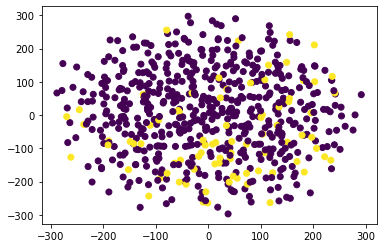

In [18]:
# Create a scatter plot
plt.scatter(tsne_features[:,0],tsne_features[:,1], c=labels)

In [29]:
# creating an elbow to identify the best number of clusters
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(myopia_pca)
    inertia.append(km.inertia_)

    
# 3.2 If possible, determine where the elbow of the plot is, and at which value of k it appears.
# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}


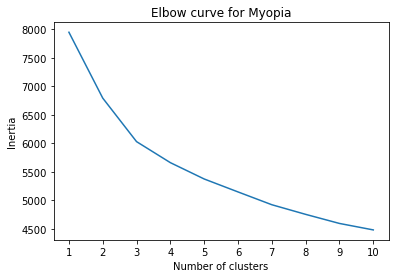

In [30]:
# Plot the elbow curve to 
plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve for Myopia')
plt.show()

In [31]:
# Create a DataFrame from the PCA transformed data for K-Means modelling and plotting
columns=[]
for i in range(len(pca.components_)):
    columns.append(i+1)
pca_df = pd.DataFrame(myopia_pca, columns=columns)
pca_df['class']= km.labels_
pca_df.head()

,1,2,3,4,5,6,7,8,9,10,class
0,0.535503,1.145004,-1.385019,0.116006,-3.226691,-1.928459,-1.958892,-1.922997,0.026753,0.178144,6
1,-0.624706,-1.575786,-0.794253,1.156287,0.292256,0.349060,-0.455206,0.285332,0.689683,-0.557031,2
2,-0.933479,-0.717076,0.820150,-1.547638,0.173941,0.272783,0.025821,-0.030817,-0.431499,0.013336,8
3,0.106354,1.192475,-0.024441,1.507469,-2.356836,-0.023139,0.236418,-1.717109,-1.230785,-0.703400,6
4,-0.388503,-2.839655,-0.229767,-0.622510,0.271458,-0.928956,0.537900,-1.301787,0.279007,0.631183,2


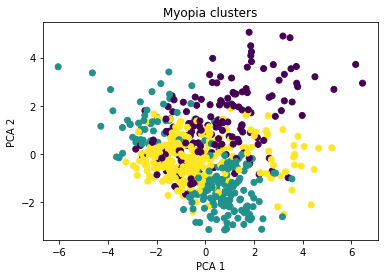

In [32]:
# Initialize the K-Means model 
model = KMeans(n_clusters=3, random_state=0)

# Train the model
model.fit(pca_df)

# Predict clusters
predictions = model.predict(pca_df)

# Create predicted clusters (labels) to DataFrame
pca_df['class'] = model.labels_

# Plot the Clusters
plt.scatter(x=pca_df[1], y=pca_df[2], c=pca_df['class'])
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Myopia clusters')
plt.show()

In [ ]:
##The optimal number of clusters seems to be 3